<a href="https://colab.research.google.com/github/Siba-mangal/Brain_tumor_detection/blob/using-keras/Brain_Tumor_Detection_CNN_Model_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [3]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            # image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [4]:
path = '/content/drive/MyDrive/dataset'

# augmented data (yes and no) contains both the original and the new generated examples
yes = path + '/yes' 
no = path + '/no'

IMG_WIDTH, IMG_HEIGHT = (256, 256)

X, y = load_data([yes, no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1464
X shape is: (1464, 256, 256, 3)
y shape is: (1464, 1)


In [5]:
def split_data(X, y, test_size=0.2):
       
    # X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25,random_state = 42)
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.25)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.25)

In [7]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1098
number of development examples = 92
number of test examples = 274
X_train shape: (1098, 256, 256, 3)
Y_train shape: (1098, 1)
X_val (dev) shape: (92, 256, 256, 3)
Y_val (dev) shape: (92, 1)
X_test shape: (274, 256, 256, 3)
Y_test shape: (274, 1)


In [8]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [9]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [10]:
from keras.layers import Dropout
from tensorflow import keras
import tensorflow as tf

Buid Model

In [13]:
# def build_model(input_shape):
#     """
#     Arugments:
#         input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
#     Returns:
#         model: A Model object.
#     """
#     # Define the input placeholder as a tensor with shape input_shape. 
#     X_input = Input(input_shape) # shape=(?, 256, 256, 3)
    
#     # Zero-Padding: pads the border of X_input with zeroes
#     X = ZeroPadding2D((2, 2))(X_input) 
    
#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
#     X = BatchNormalization(axis = 3, name = 'bn0')(X)
#     X = Activation('relu')(X) # shape=(?, 238, 238, 32)

#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    

#     X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv1')(X)
#     X = BatchNormalization(axis = 3, name = 'bn1')(X)
#     X = Activation('relu')(X) # shape=(?, 238, 238, 32)
#     # X = tf.keras.layers.Dropout(rate=0.2)
    
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

#     X = Conv2D(128, (7, 7), strides = (1, 1), name = 'conv2')(X)
#     X = BatchNormalization(axis = 3, name = 'bn2')(X)
#     X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
#     # # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool2')(X)
#     # X = keras.layers.Dropout(0.30)(X) # changed dropout rate 0.20 to 0.30
#     X = keras.layers.Dropout(0.20)(X)
 
#     # FLATTEN X 
#     X = Flatten()(X) # shape=(?, 6272)
#     # FULLYCONNECTED
#     X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    
#     # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
#     model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    
#     return model

In [ ]:
# def build_model(input_shape):
#     # Define the input placeholder as a tensor with shape input_shape. 
#     X_input = Input(input_shape)
#     X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
#     X = BatchNormalization(axis = 3, name = 'bn0')(X)
#     X = Activation('relu')(X) # 

#     # MAXPOOL
#     X = MaxPooling2D((2, 2), name='max_pool0')(X) # 
#     # X=Dropout(0.50)(X)


#     X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
#     X = BatchNormalization(axis=3, name='bn1')(X)
#     X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
#     X=Dropout(0.50)(X)

#     # FLATTEN X 
#     X = Flatten()(X) # shape=(?, 6272)
#     # FULLYCONNECTED
#     X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


#     model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

#     return model
# ------------------------------------------------
# def build_model(input_shape):
#     """
#     Arugments:
#         input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
#     Returns:
#         model: A Model object.
#     """
#     # Define the input placeholder as a tensor with shape input_shape. 
#     X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
#     # Zero-Padding: pads the border of X_input with zeroes
#     X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
#     X = BatchNormalization(axis = 3, name = 'bn0')(X)
#     X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
#     # MAXPOOL
#     X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
#     # FLATTEN X 
#     X = Flatten()(X) # shape=(?, 6272)
#     # FULLYCONNECTED
#     X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
#     # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
#     model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
#     return model

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [16]:
def build_model(input_shape):
    model = Sequential()
    #block=1
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #block=2
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #block=3
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


    return model

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [18]:
model = build_model(IMG_SHAPE)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='rmsprop', 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'],
#              )

In [21]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [22]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("./Brain_Tumor_Detection_Models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [23]:
start_time = time.time()

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time() 
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


#------------------------------
# history = model.fit(X_train,
#                     y_train,
#                     batch_size=256, 
#                     epochs=31, 
#                     validation_split=.3,
#                    )

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.7295

35/35 [==============================] - 28s 314ms/step - loss: 0.5870 - accuracy: 0.7295 - val_loss: 0.3846 - val_accuracy: 0.8696
Epoch 2/20
34/35 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.8263

35/35 [==============================] - 6s 179ms/step - loss: 0.3854 - accuracy: 0.8279 - val_loss: 0.2818 - val_accuracy: 0.8913
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8925

35/35 [==============================] - 7s 186ms/step - loss: 0.2697 - accuracy: 0.8925 - val_loss: 0.2703 - val_accuracy: 0.8804
Epoch 4/20
34/35 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9256

35/35 [==============================] - 6s 174ms/step - loss: 0.1854 - accuracy: 0.9262 - val_loss: 0.1616 - val_accuracy: 0.9348
Epoch 5/20
34/35 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9550

35/35 [==============================] - 7s 192ms/step - loss: 0.1099 - accuracy: 0.9554 - val_loss: 0.2291 - val_accuracy: 0.9239
Epoch 6/20
34/35 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9651

35/35 [==============================] - 6s 177ms/step - loss: 0.0874 - accuracy: 0.9654 - val_loss: 0.1228 - val_accuracy: 0.9565
Epoch 7/20
35/35 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9818

35/35 [==============================] - 6s 185ms/step - loss: 0.0516 - accuracy: 0.9818 - val_loss: 0.1083 - val_accuracy: 0.9457
Epoch 8/20
34/35 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963

35/35 [==============================] - 6s 177ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0738 - val_accuracy: 0.9783
Epoch 9/20
35/35 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

35/35 [==============================] - 7s 197ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.9783
Epoch 10/20
34/35 [============================>.] - ETA: 0s - loss: 9.4950e-04 - accuracy: 1.0000

35/35 [==============================] - 6s 178ms/step - loss: 9.4110e-04 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9783
Epoch 11/20
35/35 [==============================] - ETA: 0s - loss: 7.3869e-04 - accuracy: 1.0000

35/35 [==============================] - 7s 188ms/step - loss: 7.3869e-04 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 0.9891
Epoch 12/20
34/35 [============================>.] - ETA: 0s - loss: 1.0777e-04 - accuracy: 1.0000

35/35 [==============================] - 6s 178ms/step - loss: 1.0679e-04 - accuracy: 1.0000 - val_loss: 0.0452 - val_accuracy: 0.9891
Epoch 13/20
34/35 [============================>.] - ETA: 0s - loss: 6.2036e-05 - accuracy: 1.0000

35/35 [==============================] - 7s 196ms/step - loss: 6.1472e-05 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9891
Epoch 14/20
34/35 [============================>.] - ETA: 0s - loss: 4.6671e-05 - accuracy: 1.0000

35/35 [==============================] - 6s 182ms/step - loss: 4.6324e-05 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 0.9891
Epoch 15/20
35/35 [==============================] - ETA: 0s - loss: 3.7094e-05 - accuracy: 1.0000

35/35 [==============================] - 7s 188ms/step - loss: 3.7094e-05 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 0.9891
Epoch 16/20
34/35 [============================>.] - ETA: 0s - loss: 3.1013e-05 - accuracy: 1.0000

35/35 [==============================] - 6s 181ms/step - loss: 3.0732e-05 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9891
Epoch 17/20
35/35 [==============================] - ETA: 0s - loss: 2.6231e-05 - accuracy: 1.0000

35/35 [==============================] - 7s 196ms/step - loss: 2.6231e-05 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 0.9891
Epoch 18/20
34/35 [============================>.] - ETA: 0s - loss: 2.2907e-05 - accuracy: 1.0000

35/35 [==============================] - 6s 180ms/step - loss: 2.2725e-05 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9891
Epoch 19/20
35/35 [==============================] - ETA: 0s - loss: 1.9889e-05 - accuracy: 1.0000

35/35 [==============================] - 6s 186ms/step - loss: 1.9889e-05 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 0.9891
Epoch 20/20
34/35 [============================>.] - ETA: 0s - loss: 1.7490e-05 - accuracy: 1.0000

35/35 [==============================] - 6s 187ms/step - loss: 1.7507e-05 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9891
Elapsed time: 0:2:32.4


In [25]:
history = model.history.history

In [26]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [27]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

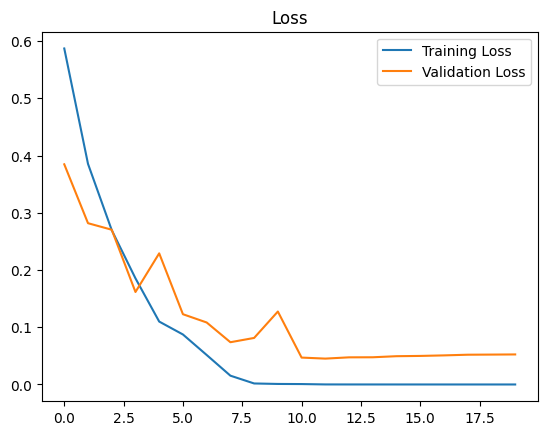

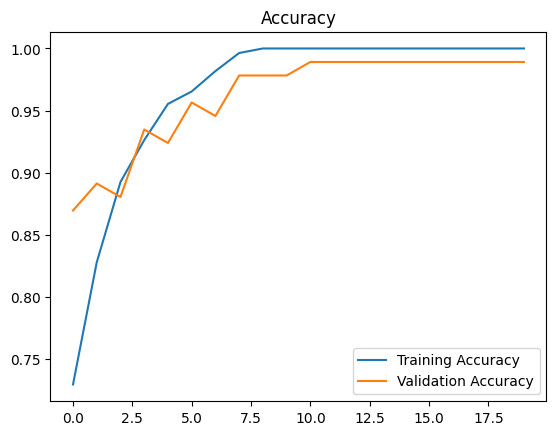

In [28]:
plot_metrics(history)

In [ ]:
loss, acc = model.evaluate(x=X_test, y=y_test)

9/9 [==============================] - 1s 76ms/step - loss: 0.0675 - accuracy: 0.9745


In [ ]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(acc))

Test Loss = 0.06754948943853378
Test Accuracy = 0.974452555179596


In [ ]:
y_test_prob = model.predict(X_test)

9/9 [==============================] - 0s 29ms/step


In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f1score)

0.9729729729729729


In [ ]:
y_val_prob = model.predict(X_val)

3/3 [==============================] - 0s 29ms/step


In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [ ]:
data_percentage(y)

Number of examples:1464
Percentage of positive examples: 50.0%, number of pos examples: 732
Percentage of negative examples: 50.0%, number of neg examples: 732


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:1098
Percentage of positive examples: 51.09289617486339%, number of pos examples: 561
Percentage of negative examples: 48.90710382513661%, number of neg examples: 537
Validation Data:
Number of examples:92
Percentage of positive examples: 47.82608695652174%, number of pos examples: 44
Percentage of negative examples: 52.17391304347826%, number of neg examples: 48
Testing Data:
Number of examples:274
Percentage of positive examples: 46.35036496350365%, number of pos examples: 127
Percentage of negative examples: 53.64963503649635%, number of neg examples: 147


In [ ]:
from PIL import Image
model_path = "/content/Brain_Tumor_Detection_Models/cnn-parameters-improvement-20-0.98.model"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Brain_dataset/pred/pred36.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((256, 256))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/256

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print('yes')
else:
  print('no')

# result = pred.argmax()
# result

1/1 [==============================] - 0s 185ms/step
no
